In [49]:
from lark import Lark
from lark.tree import pydot__tree_to_png
from lark.indenter import Indenter

import pydot
from IPython.display import Image, display

%matplotlib inline

In [50]:
class PythonIndenter(Indenter):
    NL_type = '_NEWLINE'
    OPEN_PAREN_types = ['__LPAR', '__LSQB', '__LBRACE']
    CLOSE_PAREN_types = ['__RPAR', '__RSQB', '__RBRACE']
    INDENT_type = '_INDENT'
    DEDENT_type = '_DEDENT'
    tab_len = 8

### Описание грамматики для юридического dsl

In [55]:
grammar = r""" 
                ?start: (unit | arg | dispositiv | imperativ | result | message | if_stmt)*
                
                if_stmt: "Если" union_condition "то" else
                ?union_condition: condition (logic_operator condition)*
                condition: existence_cond | comparable_cond | merge_lists_cond | unique_cond
                existence_cond: existence_operator variable
                comparable_cond: variable (action_operator variable)*
                merge_lists_cond: "в" variable existence_operator "любой" "из" array
                unique_cond: unique_operator value
                else: (complex_else | simple_else)
                complex_else: _NEWLINE _INDENT  if_stmt _DEDENT
                ?simple_else: name_result _NEWLINE
                
                message: "Сообщение" text_message "как" name_message _NEWLINE
                text_message: STRING
                name_message: VARIABLE
                
                result: "Исход" type_result text_result "как" name_result _NEWLINE
                !type_result: "Экспертиза"|"Отрицательный"
                text_result: STRING
                name_result: VARIABLE
                
                dispositiv: "Диспозитив" name ["типа" name_type] _NEWLINE
                
                imperativ: "Императив" name ["типа" name_type] _NEWLINE
                name_type: VARIABLE
                
                arg: "Аргумент" name_arg _NEWLINE
                name_arg: STRING
                
                unit: "Блок" name_unit ["как" short_name] _NEWLINE
                name_unit: STRING
                short_name: STRING 
                
                !logic_operator: "и"|"или"
                !existence_operator: "существует"|"не" "существует"
                !action_operator: "<"|"меньше"|">"|"больше"|"=="|"равно"|"равен"|">="|"<="|"!="|"не равно"|"не равен"|"содержит"|"не" "содержит"
                !unique_operator: "не" "единственное"|"единственное"
                
                array: "[" [value ("," value)*] "]"
                
                ?value: array
                      | STRING
                      | VARIABLE
                      | SIGNED_NUMBER
                      | "true"             -> true
                      | "false"            -> false
                      | "null"             -> null
                
                name: VARIABLE
                variable: VARIABLE | SIGNED_NUMBER | STRING | array
                
                !frac: SIGNED_NUMBER "/" SIGNED_NUMBER
                !date: (/[0123][\d]\.[01][\d]\.[12]\d{3}/) | (/[\d]+/ month /[12]\d{3}/)
                !period: SIGNED_NUMBER ("день"|"дня"|"дней")
                !money_sum: SIGNED_NUMBER "руб" [SIGNED_NUMBER "коп"]
                month: "января"|"февраля"|"марта"|"апреля"|"мая"|"июня"|"июля"|"августа"|"сентября"|"октября"|"ноября"|"декабря"
                VARIABLE: /[а-яА-Я][\w.]*/
                STRING: /[ubf]?r?("(?!"").*?(?<!\\)(\\\\)*?"|'(?!'').*?(?<!\\)(\\\\)*?')/i
                COMMENT: /#[^\n]*/
                _NEWLINE: ( /\r?\n[\t ]*/ | COMMENT )+
                
                %import common.ESCAPED_STRING
                %import common.SIGNED_NUMBER
                %import common.WS
                %ignore WS
                %ignore COMMENT

                _DEDENT: "<DEDENT>"
                _INDENT: "<INDENT>"  """

## Проверка корректности грамматики для примеров

In [56]:
with open('test_dsl.txt', 'r') as f:
    file = f.read()

In [57]:
print(file)

Блок "Проверка правоспособности АО на основании данных ЕГРЮЛ"


Императив ЕГРЮЛ.ОГРН
Императив ЕГРЮЛ.ПНЮЛ
Императив ЕГРЮЛ.РазмерУК типа Денежная_сумма
Императив ЕГРЮЛ_МН типа Список

Диспозитив ЕГРЮЛ.КорпДог
Диспозитив ЕГРЮЛ.Ликвидация
Диспозитив ЕГРЮЛ.ОсобОтметки
Диспозитив ЕГРЮЛ.Лицензии
Диспозитив ЕГРЮЛ.Реорганизация

Диспозитив ЕГРЮЛ.ЕИО_УК.СвРегИн
Диспозитив ЕГРЮЛ.СведУмУк
Диспозитив ЕГРЮЛ.СвПрекрЮл
Диспозитив ЕГРЮЛ.СвРешИсклЮл
Диспозитив ЕГРЮЛ.СвСтатус.КодСтатусЮл
Диспозитив ЕГРЮЛ.СвРешИзмМН
Диспозитив ЕГРЮЛ.СвСтатус

Императив ЕГРЮЛ.Регистратор

# Объявление исходов

Исход Экспертиза "Ошибка выписки (запросить корректную выписку)." как Ошибка_выписки
Исход Экспертиза "Требуется ручная обработка." как Ручная_обработка
Исход Экспертиза "Противоречивость данных. Требуется ручная обработка." как Противоречие
Исход Отрицательный "Отрицательный результат проверки" как Отрицательный_исход

Сообщение "Общество осуществляет свою деятельность на основании лицензии." как Сообщение_о_лиценз

In [58]:
json_parser = Lark(grammar, parser='lalr', postlex=PythonIndenter(), start='start')

In [59]:
tree = json_parser.parse(file)

### Построение дерева

In [60]:
def load_tree_image(tree, path):
    pydot__tree_to_png(tree, path)
    display(Image(path))

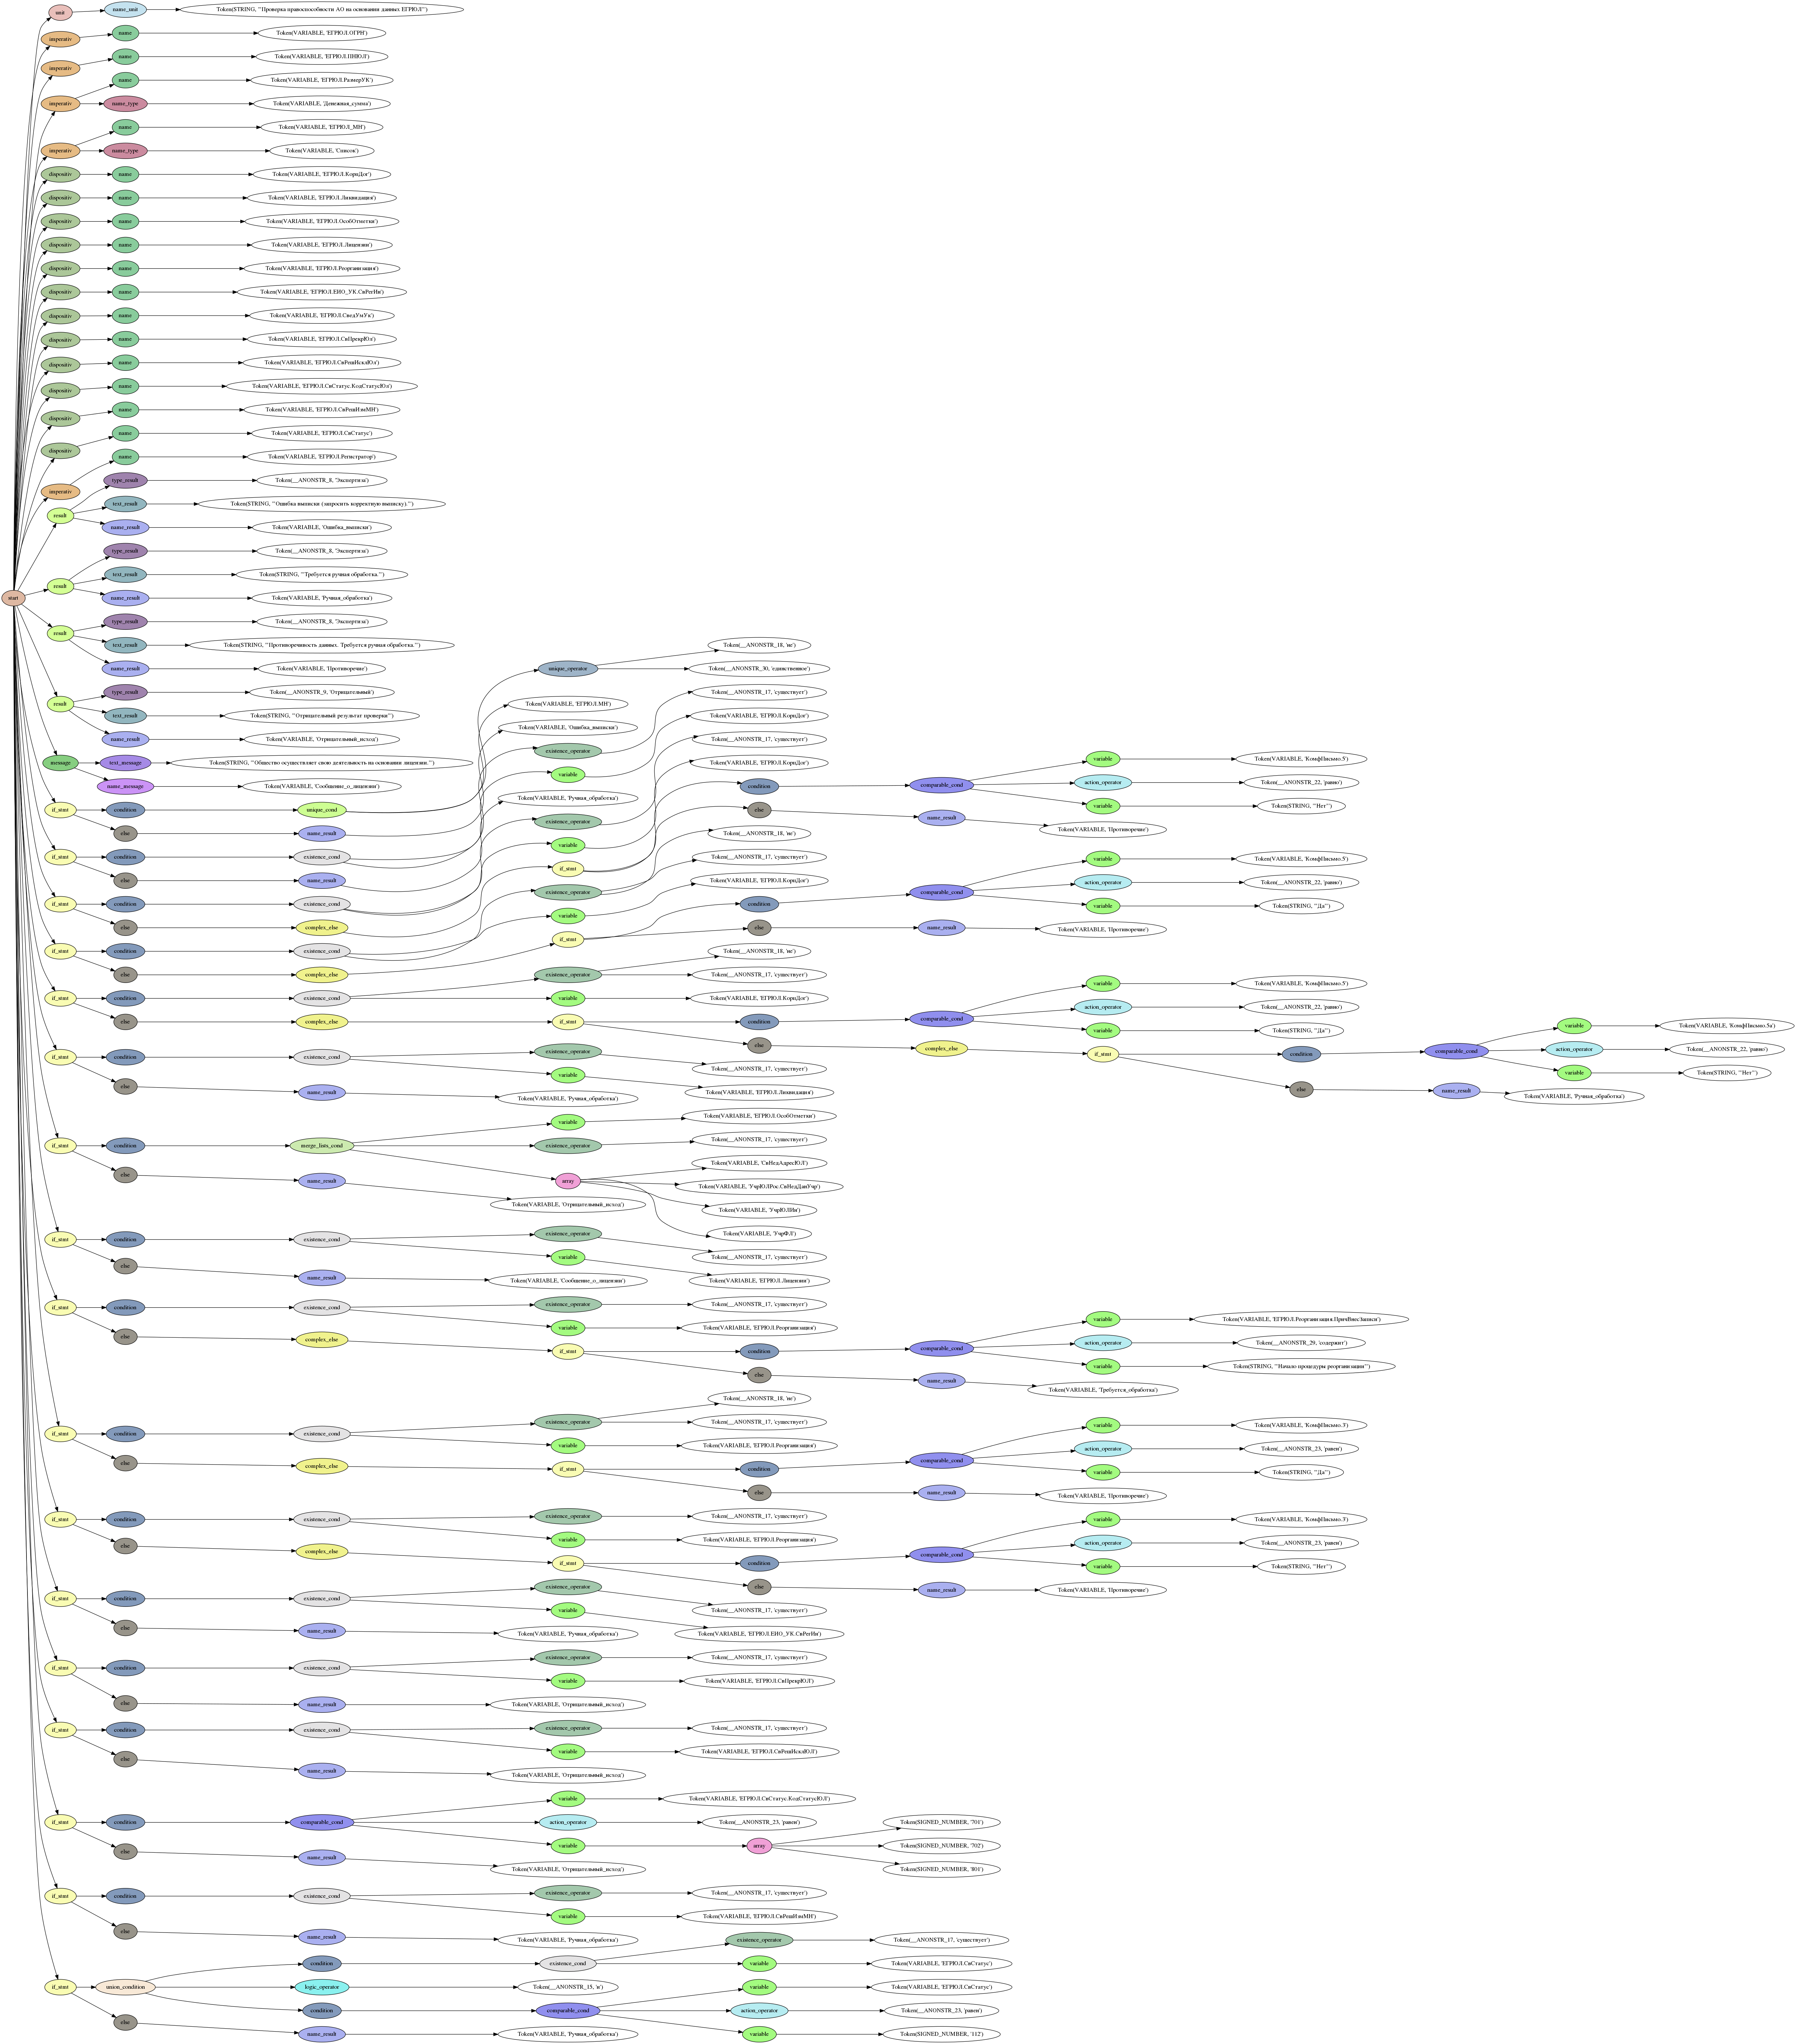

In [61]:
load_tree_image(tree, 'tree-dsl.png')